# RNN, LSTM, GRU, Transformer을 활용한 주가예측

### 사전 작업

In [ ]:
# pip install
!pip install -U finance-datareader
!pip install statsmodels
!pip install plotly==5.11.0
!pip install kaleido
!pip install statsmodels
!pip install pystan
!pip install prophet

In [ ]:
# 필요 모듈
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler #Robust스케일러
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
from tensorflow.keras import layers
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from keras.callbacks import ModelCheckpoint
from scipy.stats import kstest
from prophet import Prophet
from datetime import datetime

### 종목 코드 얻기

In [ ]:
def make_code(x):
    x = str(x)
    return '0'*(6-len(x)) + x

code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download',header=0)[0]
code_data['종목코드'] = code_data['종목코드'].apply(make_code)
code_list = code_data[code_data['상장일'] < '2023-12-31']['종목코드']
code_data

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
1,CJ제일제당,097950,기타 식품 제조업,"설탕,소맥분,조미식품,육가공식품(돈육,돼지비계,돼지식용설육),대두가공식품,사료,의약...",2007-09-28,12월,"손경식,강신호(각자 대표이사)",http://www.cj.co.kr,서울특별시
2,DRB동일,004840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://www.drbworld.com,부산광역시
3,E1,017940,기타 전문 도매업,"LPG(프로판,부탄가스),가스기기판매",1997-08-27,12월,"구자용, 천정식 (각자 대표이사)",http://www.e1.co.kr,서울특별시
4,HDC,012630,기타 금융업,"토목공사,건축공사,아파트분양사업,재개발/재건축사업",1996-10-16,12월,"정몽규, 정경구",http://www.i-park.com,서울특별시
...,...,...,...,...,...,...,...,...,...
2686,타스컴,336040,의료용 기기 제조업,당뇨질환 세포치료제 / 당뇨관리 의료기기,2019-12-02,12월,이인근,http://www.yidobio.com,경기도
2687,테크엔,308700,전구 및 조명장치 제조업,LED조명장치,2018-12-21,12월,박철,http://www.techen.co.kr,대구광역시
2688,파워풀엑스,266870,기타 화학제품 제조업,플렉스파워 리커버리크림,2017-04-24,12월,박인철,http://www.flexpower.co.kr,서울특별시
2689,펨토바이오메드,327610,의료용 기기 제조업,CellShot 플랫폼 / CellShot 기반 항암백신치료 제품군 / CellSh...,2019-07-10,12월,"이상현, 최주현(각자대표)",http://www.femtobiomed.com,경기도


### ETF 종류 확인

In [ ]:
# ETF종류 확인
df_etf = fdr.StockListing("ETF/KR")
df_etf

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,459580,6,KODEX CD금리액티브(합성),1035050,2,100,0.01,1035051.0,0.9018,148310,153508,83074
1,357870,6,TIGER CD금리투자KIS(합성),54255,2,5,0.01,54252.0,0.9020,113443,6155,73390
2,069500,1,KODEX 200,37295,2,810,2.22,37303.0,3.9666,2041431,75941,64054
3,423160,6,KODEX KOFR금리액티브(합성),106680,2,10,0.01,106667.0,0.8986,984487,105026,52334
4,449170,6,TIGER KOFR금리액티브(합성),105215,2,10,0.01,105210.0,0.9063,26605,2799,37317
...,...,...,...,...,...,...,...,...,...,...,...,...
851,412560,2,TIGER BBIG레버리지,2215,2,35,1.61,2222.0,-3.5399,10363,23,19
852,252730,2,KBSTAR 모멘텀로우볼,16010,2,125,0.79,16126.0,5.7942,22,0,16
853,287330,2,KBSTAR 200생활소비재,6420,2,20,0.31,6441.0,8.4194,240,1,14
854,315480,2,KBSTAR 200커뮤니케이션서비스,11005,2,135,1.24,11006.0,-4.7578,57,0,13


In [ ]:
# KODEX 200 데이터 프레임으로 확인
df = fdr.DataReader('069500')
df.head(12)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-14,5199,5333,5058,5184,2944210,NaN
2002-10-15,5234,5316,5133,5312,2614294,0.024691
2002-10-16,5359,5359,5272,5335,2329345,0.004330
2002-10-17,5322,5457,5249,5410,2389214,0.014058
2002-10-18,5541,5671,5505,5642,1509280,0.042884
2002-10-21,5605,5605,5475,5488,2441023,-0.027295
2002-10-22,5570,5570,5301,5366,2986319,-0.022230
2002-10-23,5349,5511,5271,5525,2859157,0.029631
2002-10-24,5537,5583,5416,5505,2478914,-0.003620


### KODEX 200

In [ ]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-14,5199,5333,5058,5184,2944210,NaN
2002-10-15,5234,5316,5133,5312,2614294,0.024691
2002-10-16,5359,5359,5272,5335,2329345,0.004330
2002-10-17,5322,5457,5249,5410,2389214,0.014058
2002-10-18,5541,5671,5505,5642,1509280,0.042884
...,...,...,...,...,...,...
2024-04-29,36465,36550,36310,36520,3692589,0.009816
2024-04-30,36540,36865,36455,36650,5097163,0.003560
2024-05-02,36355,36615,36335,36515,3981801,-0.003683


In [ ]:
df.shape

(5331, 6)

In [ ]:
df.ndim

2

In [ ]:
# x값과 y값을 분리
dfx = df[['Open','High','Low','Volume', 'Close']]
dfy = dfx[['Close']] # y : 종가
dfx = dfx[['Open','High','Low','Volume']] # x : 나머지

In [ ]:
dfx

,Open,High,Low,Volume
Date,,,,
2002-10-14,5199,5333,5058,2944210
2002-10-15,5234,5316,5133,2614294
2002-10-16,5359,5359,5272,2329345
2002-10-17,5322,5457,5249,2389214
2002-10-18,5541,5671,5505,1509280
...,...,...,...,...
2024-04-29,36465,36550,36310,3692589
2024-04-30,36540,36865,36455,5097163
2024-05-02,36355,36615,36335,3981801


In [ ]:
dfy

,Close
Date,
2002-10-14,5184
2002-10-15,5312
2002-10-16,5335
2002-10-17,5410
2002-10-18,5642
...,...
2024-04-29,36520
2024-04-30,36650
2024-05-02,36515


In [ ]:
print("x값들의 형태와 차원은 각각 :", dfx.shape, ",", dfx.ndim, "이다")
print("x값들의 형태와 차원은 각각 :", dfy.shape, ",", dfy.ndim, "이다")

x값들의 형태와 차원은 각각 : (5331, 4) , 2 이다
x값들의 형태와 차원은 각각 : (5331, 1) , 2 이다


### EDA

In [ ]:
dfx

,Open,High,Low,Volume
Date,,,,
2002-10-14,5199,5333,5058,2944210
2002-10-15,5234,5316,5133,2614294
2002-10-16,5359,5359,5272,2329345
2002-10-17,5322,5457,5249,2389214
2002-10-18,5541,5671,5505,1509280
...,...,...,...,...
2024-04-29,36465,36550,36310,3692589
2024-04-30,36540,36865,36455,5097163
2024-05-02,36355,36615,36335,3981801


In [ ]:
dfy

,Close
Date,
2002-10-14,5184
2002-10-15,5312
2002-10-16,5335
2002-10-17,5410
2002-10-18,5642
...,...
2024-04-29,36520
2024-04-30,36650
2024-05-02,36515


##### Lineplot

In [ ]:
# KODEX200 LinePlot : (price, date)
fig = px.line(data_frame= dfy, color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

In [ ]:
# KODEX200 LinePlot : (open, date)
fig = px.line(data_frame= dfx['Open'], color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

In [ ]:
# KODEX200 LinePlot : (High, date)
fig = px.line(data_frame= dfx['High'], color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

In [ ]:
# KODEX200 LinePlot : (Low, date)
fig = px.line(data_frame= dfx["Low"], color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

In [ ]:
# KODEX200 LinePlot : (Volume, date)
fig = px.line(data_frame= dfx["Volume"], color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

##### 상관관계

In [ ]:
# 상관관계 확인
df.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999889,0.999847,0.999723,0.450708,-0.021130
High,0.999889,1.000000,0.999818,0.999863,0.452058,-0.013818
Low,0.999847,0.999818,1.000000,0.999879,0.447323,-0.011609
Close,0.999723,0.999863,0.999879,1.000000,0.448930,-0.004185
Volume,0.450708,0.452058,0.447323,0.448930,1.000000,-0.085622
Change,-0.021130,-0.013818,-0.011609,-0.004185,-0.085622,1.000000


<Axes: >

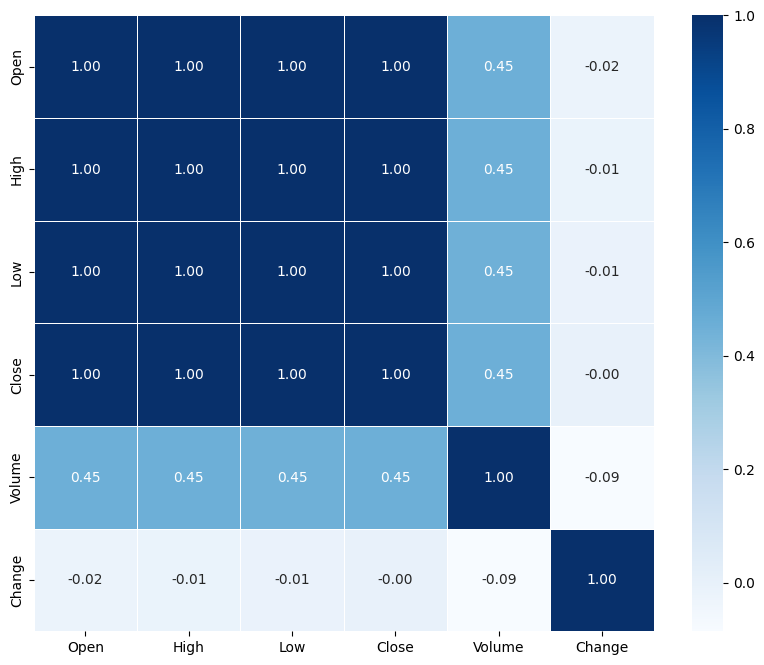

In [ ]:
# 히트맵
plt.figure(figsize=(10,8))
sns.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

##### 정상성 판단

In [ ]:
# 정상성 판단(시계열 자료)
result = adfuller(dfy['Close'])
result

(-0.9250311489721862,
 0.7796175878408349,
 11,
 5319,
 {'1%': -3.4315800166692987,
  '5%': -2.862083541535917,
  '10%': -2.56705932658522},
 73677.54402486024)

**H0** : 시계열 자료에 단위근이 존재한다 vs **H1** : 시계열 자료가 정상성을 만족한다.

p-value가 0.756이므로 귀무가설 H0를 기각할 수 없다.
따라서 종가는 비정상성이다.

추세와 계절성을 제거하기 위해 회귀모델로 진행하겠다.

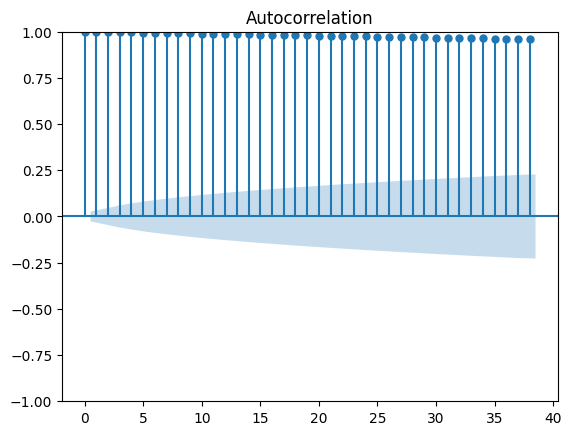

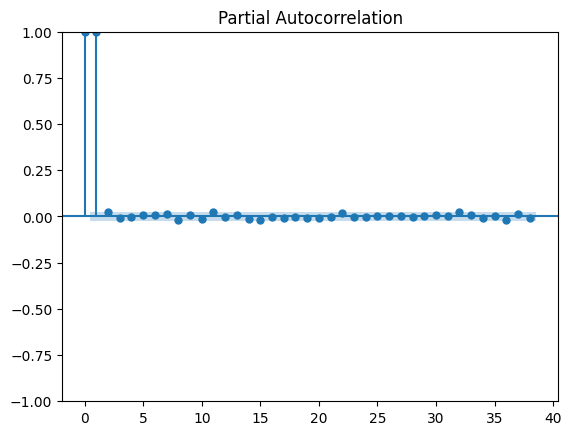

In [ ]:
# 일일 종가의 자기상관함수 & 편자기상관함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dfy['Close'])
plot_pacf(dfy['Close'])
plt.show()

##### 시계열 분석

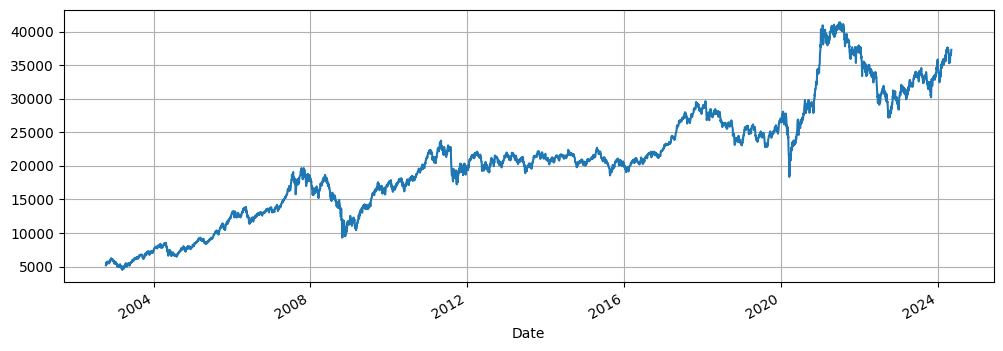

In [ ]:
# 종가 주기성 판단
dfy['Close'].plot(figsize = (12, 4), grid = True);

In [ ]:
# 종가 데이터프레임 나누기
df2 = pd.DataFrame({'ds': dfy.index, 'y': dfy['Close']})
df2.reset_index(inplace = True)

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df2['Date']

df2.head()

,ds,y
0,2002-10-14,5184
1,2002-10-15,5312
2,2002-10-16,5335
3,2002-10-17,5410
4,2002-10-18,5642


In [ ]:
# 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다
m = Prophet(daily_seasonality = True)
m.fit(df2);

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllw5tyt5/ioi64crq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllw5tyt5/yqwx_n1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47775', 'data', 'file=/tmp/tmpllw5tyt5/ioi64crq.json', 'init=/tmp/tmpllw5tyt5/yqwx_n1x.json', 'output', 'file=/tmp/tmpllw5tyt5/prophet_modele3a9r43z/prophet_model-20240507023310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# 1년(365일) 후. 즉, 2017년 12월 31일까지의 데이터를 예측하겠다는 의미
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
5691,2025-05-03
5692,2025-05-04
5693,2025-05-05
5694,2025-05-06
5695,2025-05-07


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5691,2025-05-03,37487.574298,34171.456148,41290.322137
5692,2025-05-04,37470.087844,33972.377623,40970.654371
5693,2025-05-05,37420.108155,33920.477703,41121.228312
5694,2025-05-06,37426.067978,34044.499509,41044.341154
5695,2025-05-07,37385.149217,33942.202683,41138.408215


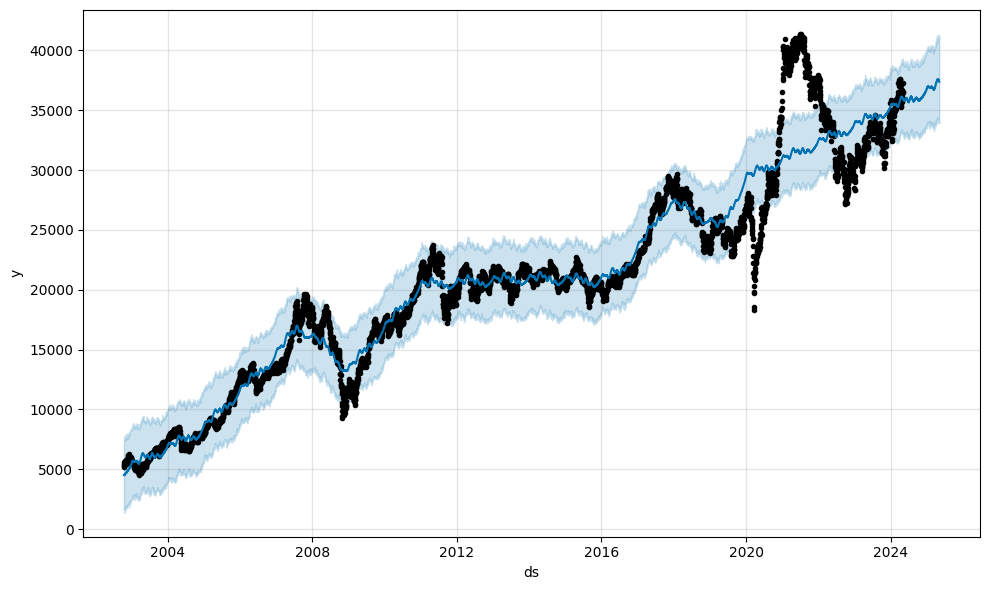

In [ ]:
m.plot(forecast);

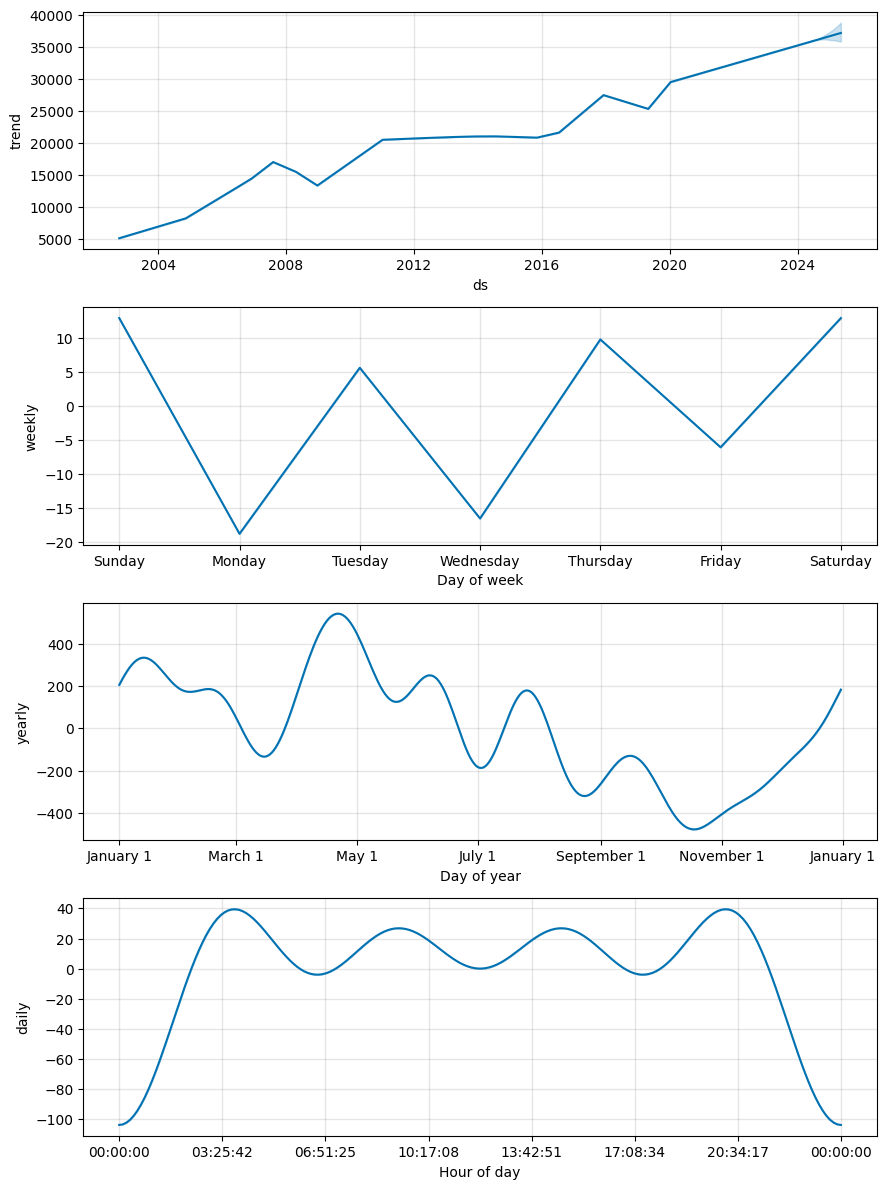

In [ ]:
m.plot_components(forecast);

### 데이터 전처리

In [ ]:
# 이상치, 결측치에 영향을 최대한 적게 받기 위해 로버스트 스케일링 진행
rs = RobustScaler()
dfx_scaler = rs.fit_transform(dfx)
dfy_scaler = rs.fit_transform(dfy)

data_x = pd.DataFrame(dfx_scaler)
data_y = pd.DataFrame(dfy_scaler)

In [ ]:
X = data_x.values.tolist()
y = data_y.values.tolist()

In [ ]:
# 10일데이터를 가지고 다음날을 예측
window_size = 10

data_x = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[1.2836318932209343, 1.2803991946073712, 1.2416137005649717, 2.418394115115844], [1.2992623814541622, 1.3092882780355424, 1.3030543785310735, 0.7411747458827408], [1.321390937829294, 1.3158539788146721, 1.3201800847457628, 0.12903426039403806], [1.3535300316122234, 1.3655782193819488, 1.370321327683616, 0.31976100006371533], [1.3295574288724974, 1.3283725816335463, 1.3301553672316384, -0.34401005861990464], [1.3465929048120828, 1.3465814584609996, 1.3449858757062148, -0.038655289438175255], [1.3760098349139445, 1.3703930666199773, 1.3792372881355932, -0.15455963323353702], [1.3825957147874957, 1.3979690098923225, 1.3920374293785311, 0.10186689489768216], [1.3663505444327362, 1.3760833406285564, 1.381444209039548, -0.10175954647848805], [1.414207938180541, 1.402783857130351, 1.393361581920904, 0.3116709822069995]] -> [1.4487337319732676]


In [ ]:
# train, test, val데이터
train_size = int(len(data_y) * 0.6)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = int(len(data_y) * 0.2)
test_x = np.array(data_x[train_size : train_size + test_size])
test_y = np.array(data_y[train_size : train_size + test_size])

val_size = int(len(data_y) * 0.2)
val_x = np.array(data_x[train_size + test_size : ])
val_y = np.array(data_y[train_size + test_size : ])

print('훈련 데이터의 크기 :', train_x.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_x.shape, test_y.shape)
print('val 데이터의 크기 :', val_x.shape, val_y.shape)

훈련 데이터의 크기 : (3192, 10, 4) (3192, 1)
테스트 데이터의 크기 : (1064, 10, 4) (1064, 1)
val 데이터의 크기 : (1065, 10, 4) (1065, 1)


### LSTM 모델링

In [ ]:
# 층구조
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 20)            2000      
                                                                 
 dropout_4 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5301 (20.71 KB)
Trainable params: 5301 (20.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer = "adam", loss = "mse")

In [ ]:
# 모델 fit
es = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
checkpoint = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks = [es, checkpoint]
model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks = callbacks)

Epoch 1/100
107/107 [==============================] - ETA: 0s - loss: 0.0783
Epoch 1: val_loss improved from -inf to 1.00315, saving model to weights.h5
107/107 [==============================] - 6s 33ms/step - loss: 0.0783 - val_loss: 1.0031
Epoch 2/100
105/107 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 2: val_loss improved from 1.00315 to 198.00452, saving model to weights.h5
107/107 [==============================] - 3s 28ms/step - loss: 0.0172 - val_loss: 198.0045
Epoch 3/100
107/107 [==============================] - ETA: 0s - loss: 0.0138
Epoch 3: val_loss did not improve from 198.00452
107/107 [==============================] - 2s 23ms/step - loss: 0.0138 - val_loss: 168.8505
Epoch 4/100
105/107 [============================>.] - ETA: 0s - loss: 0.0117
Epoch 4: val_loss did not improve from 198.00452
107/107 [==============================] - 3s 24ms/step - loss: 0.0117 - val_loss: 140.5233
Epoch 5/100
105/107 [============================>.] - ETA: 0s - lo

In [ ]:
# # 이전에 저장된 모델 가중치를 불러옵니다.
# model.load_weights("weights.h5")

# # 이어서 모델을 학습합니다.
# model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks=callbacks)

# # 모델 훈련 후 HDF5 파일에 저장하기
# model.save('model.h5')

# # 저장된 모델 로드하기
# from tensorflow.keras.models import load_model

# model = load_model('model.h5')

In [ ]:
# R2값 계산
pred_y = model.predict(test_x)
from sklearn.metrics import r2_score
r2_y_predict_LSTM = r2_score(test_y, pred_y)
print('R2 : ', r2_y_predict_LSTM)

34/34 [==============================] - 0s 4ms/step
R2 :  0.9690340958582253


34/34 [==============================] - 0s 4ms/step


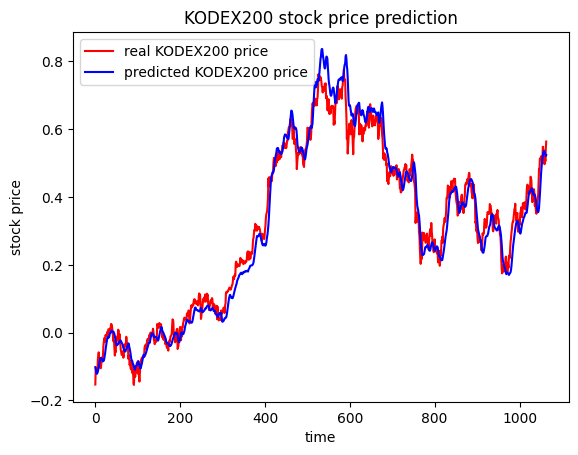

내일 KODEX 주가 : [0.5237079] KRW


In [ ]:
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real KODEX200 price')
plt.plot(pred_y, color='blue', label='predicted KODEX200 price')
plt.title('KODEX200 stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
predLSTM = df.Close[-1] * pred_y[-1] / dfy.Close[-1]

print("내일 KODEX 주가 :", predLSTM, 'KRW')

### RNN 모델링

In [ ]:
# 층구조
model = Sequential()
model.add(SimpleRNN(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(SimpleRNN(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 20)            500       
                                                                 
 dropout_6 (Dropout)         (None, 10, 20)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1341 (5.24 KB)
Trainable params: 1341 (5.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer = "adam", loss = "mse")

In [ ]:
# 모델 fit
es = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
checkpoint = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks = [es, checkpoint]
model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks = callbacks)

Epoch 1/100
106/107 [============================>.] - ETA: 0s - loss: 0.0565
Epoch 1: val_loss improved from -inf to 4.34058, saving model to weights.h5
107/107 [==============================] - 4s 18ms/step - loss: 0.0565 - val_loss: 4.3406
Epoch 2/100
106/107 [============================>.] - ETA: 0s - loss: 0.0255
Epoch 2: val_loss did not improve from 4.34058
107/107 [==============================] - 2s 15ms/step - loss: 0.0255 - val_loss: 4.1713
Epoch 3/100
105/107 [============================>.] - ETA: 0s - loss: 0.0189
Epoch 3: val_loss did not improve from 4.34058
107/107 [==============================] - 2s 16ms/step - loss: 0.0189 - val_loss: 3.7183
Epoch 4/100
106/107 [============================>.] - ETA: 0s - loss: 0.0144
Epoch 4: val_loss did not improve from 4.34058
107/107 [==============================] - 2s 15ms/step - loss: 0.0144 - val_loss: 3.1128
Epoch 5/100
104/107 [============================>.] - ETA: 0s - loss: 0.0121
Epoch 5: val_loss did not improve

In [ ]:
# # 이전에 저장된 모델 가중치를 불러옵니다.
# model.load_weights("weights.h5")

# # 이어서 모델을 학습합니다.
# model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks=callbacks)

# # 모델 훈련 후 HDF5 파일에 저장하기
# model.save('model.h5')

# # 저장된 모델 로드하기
# from tensorflow.keras.models import load_model

# model = load_model('model.h5')

In [ ]:
# R2값 계산
pred_y = model.predict(test_x)
from sklearn.metrics import r2_score
r2_y_predict_RNN = r2_score(test_y, pred_y)
print('R2 : ', r2_y_predict_RNN)

34/34 [==============================] - 0s 3ms/step
R2 :  0.6601306772061455


34/34 [==============================] - 0s 3ms/step


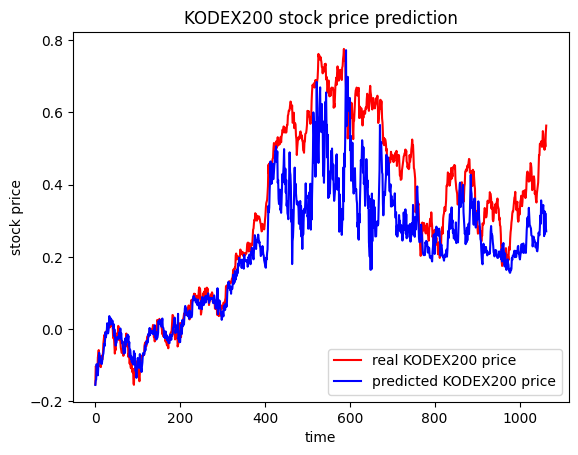

내일 KODEX 주가 : [0.27082056] KRW


In [ ]:
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real KODEX200 price')
plt.plot(pred_y, color='blue', label='predicted KODEX200 price')
plt.title('KODEX200 stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
predRNN = df.Close[-1] * pred_y[-1] / dfy.Close[-1]

print("내일 KODEX 주가 :", predRNN, 'KRW')

### GRU 모델링

In [ ]:
# 층구조
model = Sequential()
model.add(GRU(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(GRU(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 20)            1560      
                                                                 
 dropout_8 (Dropout)         (None, 10, 20)            0         
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4101 (16.02 KB)
Trainable params: 4101 (16.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer = "adam", loss = "mse")

In [ ]:
# 모델 fit
es = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
checkpoint = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks = [es, checkpoint]
model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks = callbacks)

Epoch 1/100
107/107 [==============================] - ETA: 0s - loss: 0.1228
Epoch 1: val_loss improved from -inf to 0.58812, saving model to weights.h5
107/107 [==============================] - 6s 33ms/step - loss: 0.1228 - val_loss: 0.5881
Epoch 2/100
107/107 [==============================] - ETA: 0s - loss: 0.0140
Epoch 2: val_loss did not improve from 0.58812
107/107 [==============================] - 3s 30ms/step - loss: 0.0140 - val_loss: 0.4911
Epoch 3/100
106/107 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 3: val_loss did not improve from 0.58812
107/107 [==============================] - 3s 30ms/step - loss: 0.0101 - val_loss: 0.4008
Epoch 4/100
107/107 [==============================] - ETA: 0s - loss: 0.0084
Epoch 4: val_loss did not improve from 0.58812
107/107 [==============================] - 3s 29ms/step - loss: 0.0084 - val_loss: 0.1793
Epoch 5/100
106/107 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 5: val_loss did not improve

In [ ]:
# # 이전에 저장된 모델 가중치를 불러옵니다.
# model.load_weights("weights.h5")

# # 이어서 모델을 학습합니다.
# model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks=callbacks)

# # 모델 훈련 후 HDF5 파일에 저장하기
# model.save('model.h5')

# # 저장된 모델 로드하기
# from tensorflow.keras.models import load_model

# model = load_model('model.h5')

In [ ]:
# R2값 계산
pred_y = model.predict(test_x)
from sklearn.metrics import r2_score
r2_y_predict_GRU = r2_score(test_y, pred_y)
print('R2 : ', r2_y_predict_GRU)

34/34 [==============================] - 0s 5ms/step
R2 :  0.9839063216097191


34/34 [==============================] - 0s 5ms/step


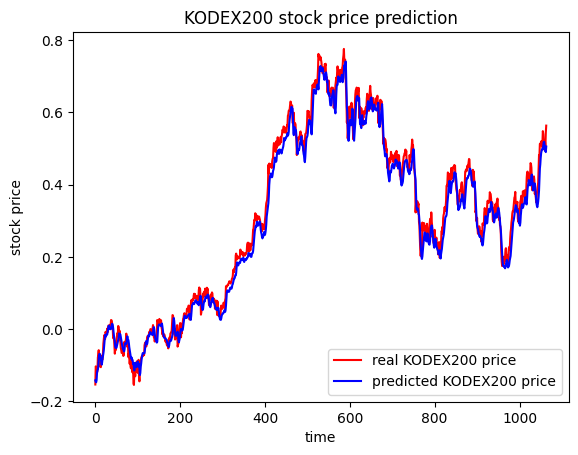

내일 KODEX 주가 : [0.5057161] KRW


In [ ]:
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real KODEX200 price')
plt.plot(pred_y, color='blue', label='predicted KODEX200 price')
plt.title('KODEX200 stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
predGRU = df.Close[-1] * pred_y[-1] / dfy.Close[-1]

print("내일 KODEX 주가 :", predGRU, 'KRW')

In [ ]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-14,5199,5333,5058,5184,2944210,NaN
2002-10-15,5234,5316,5133,5312,2614294,0.024691
2002-10-16,5359,5359,5272,5335,2329345,0.004330
2002-10-17,5322,5457,5249,5410,2389214,0.014058
2002-10-18,5541,5671,5505,5642,1509280,0.042884
...,...,...,...,...,...,...
2024-04-29,36465,36550,36310,36520,3692589,0.009816
2024-04-30,36540,36865,36455,36650,5097163,0.003560
2024-05-02,36355,36615,36335,36515,3981801,-0.003683


### Transformer 모델링

In [ ]:
# 트랜스포머 블록을 정의하는 함수
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 멀티헤드 어텐션
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward 네트워크
    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(inputs.shape[-1])(ff)
    ff = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return ff

# 입력 텐서
input_shape = (10, 4)  # 각 시퀀스의 길이는 10, 특징의 차원은 4
inputs = keras.Input(shape=input_shape)

# 트랜스포머 블록 추가
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)

# 최종적으로 Global Average Pooling을 사용
x = layers.GlobalAveragePooling1D()(x)

# 분류 또는 회귀 작업에 따른 출력 레이어
outputs = layers.Dense(1)(x)  # 여기서는 예를 들어 회귀를 예시로 함

# 모델 구성
model = keras.Model(inputs=inputs, outputs=outputs)

# 모델 컴파일
model.compile(optimizer="adam", loss="mse")  # 회귀의 경우 MSE 손실 함수 사용

# 모델 요약
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 4)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 10, 4)                4868      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout_10 (Dropout)        (None, 10, 4)                0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 10, 4)                0         ['dropout_10[0][0]',      

In [ ]:
# 모델 fit
es = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
checkpoint = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks = [es, checkpoint]
model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks = callbacks)

Epoch 1/100
105/107 [============================>.] - ETA: 0s - loss: 0.1377
Epoch 1: val_loss improved from -inf to 1.10732, saving model to weights.h5
107/107 [==============================] - 4s 9ms/step - loss: 0.1362 - val_loss: 1.1073
Epoch 2/100
100/107 [===========================>..] - ETA: 0s - loss: 0.0188
Epoch 2: val_loss did not improve from 1.10732
107/107 [==============================] - 1s 6ms/step - loss: 0.0186 - val_loss: 0.4490
Epoch 3/100
101/107 [===========================>..] - ETA: 0s - loss: 0.0131
Epoch 3: val_loss did not improve from 1.10732
107/107 [==============================] - 1s 6ms/step - loss: 0.0130 - val_loss: 0.1070
Epoch 4/100
 98/107 [==========================>...] - ETA: 0s - loss: 0.0114
Epoch 4: val_loss did not improve from 1.10732
107/107 [==============================] - 1s 6ms/step - loss: 0.0113 - val_loss: 0.0821
Epoch 5/100
 98/107 [==========================>...] - ETA: 0s - loss: 0.0085
Epoch 5: val_loss did not improve fro

In [ ]:
# # 이전에 저장된 모델 가중치를 불러옵니다.
# model.load_weights("weights.h5")

# # 이어서 모델을 학습합니다.
# model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data = (val_x, val_y), callbacks=callbacks)

# # 모델 훈련 후 HDF5 파일에 저장하기
# model.save('model.h5')

# # 저장된 모델 로드하기
# from tensorflow.keras.models import load_model

# model = load_model('model.h5')

In [ ]:
# R2값 계산
pred_y = model.predict(test_x)
from sklearn.metrics import r2_score
r2_y_predict_Transformer = r2_score(test_y, pred_y)
print('R2 : ', r2_y_predict_Transformer)

34/34 [==============================] - 0s 2ms/step
R2 :  0.6568390985544096


34/34 [==============================] - 0s 2ms/step


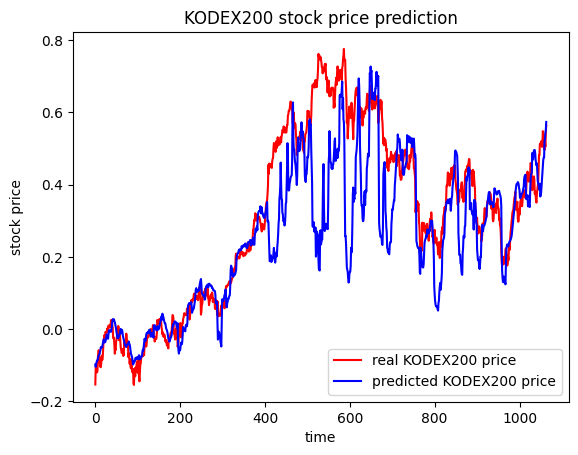

내일 KODEX 주가 : [0.5738336] KRW


In [ ]:
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real KODEX200 price')
plt.plot(pred_y, color='blue', label='predicted KODEX200 price')
plt.title('KODEX200 stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
predTransformer = df.Close[-1] * pred_y[-1] / dfy.Close[-1]

print("내일 KODEX 주가 :", predTransformer, 'KRW')

### 결론

###### R2값 비교

In [ ]:
print("LSTM :", r2_y_predict_LSTM)
print("RNN :", r2_y_predict_RNN)
print("GRU :", r2_y_predict_GRU)
print("Transformer :", r2_y_predict_Transformer)

LSTM : 0.9690340958582253
RNN : 0.6601306772061455
GRU : 0.9839063216097191
Transformer : 0.6568390985544096


##### 예측가 비교

In [ ]:
print("LSTM :", predLSTM)
print("RNN :", predRNN)
print("GRU :", predGRU)
print("Transformer :", predTransformer)

LSTM : [0.5237079]
RNN : [0.27082056]
GRU : [0.5057161]
Transformer : [0.5738336]
